# CS6700 : Tutorial 1 - Multi-Arm Bandits

![image.png](attachment:image.png)

        Goal: Analysis 3 types of sampling strategy in a MAB

### Import dependencies

In [2]:
# !pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, List

### Gaussian Bandit Environment

In [3]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)

  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [4]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [16]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self, ts: int) -> int:
    return np.random.choice(self.arm_ids)

In [6]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.Q[arm_id] = self.Q[arm_id] + ((arm_reward - self.Q[arm_id])/(sum(num for num in self.num_pulls_per_arm)))
    self.num_pulls_per_arm[arm_id] = self.num_pulls_per_arm[arm_id] + 1
    pass

  def select_arm(self, ts: int) -> int:
    # your code for selecting arm based on epsilon greedy policy
    prob = np.random.uniform(0,1)
    if prob < self.epsilon:
      arm = np.random.randint(0,5)
    else:
      arm = max(self.Q,key=self.Q.get)
    return arm


In [7]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.Q[arm_id] = self.Q[arm_id] + ((arm_reward - self.Q[arm_id])/(sum(num for num in self.num_pulls_per_arm)))
    self.num_pulls_per_arm[arm_id] = self.num_pulls_per_arm[arm_id] + 1
    pass

  def select_arm(self, ts: int) -> int:
    # your code for selecting arm based on softmax policy
    dr = 0
    for i in self.arm_ids:
        dr = dr+np.exp(self.Q[i]/self.tau)
    # sumQ = np.asarray(sum(np.exp(q/self.tau) for q in self.Q))
    piA = np.asarray(((np.exp(q/self.tau)/dr) for q in self.Q))
    arm = piA.argmax()
    return arm


In [8]:
class UCB(BasePolicy):
  # your code here
  def __init__(self, c, arm_ids):
    self.c = c
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'UCB c:{self.c}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.Q[arm_id] = self.Q[arm_id] + ((arm_reward - self.Q[arm_id])/(sum(num for num in self.num_pulls_per_arm)))
    self.num_pulls_per_arm[arm_id] = self.num_pulls_per_arm[arm_id] + 1
    pass

  def select_arm(self, ts: int) -> int:
    # your code for selecting arm based on softmax policy
    if ts < 5:
        return ts
    else:
        nr = 0
        for i in self.arm_ids:
            nr = nr+self.num_pulls_per_arm[i]
        self.x = {id:0 for id in self.arm_ids}
        for i in self.arm_ids:
            self.x[i] = self.Q[i] + self.c*(np.sqrt(np.log(nr/self.num_pulls_per_arm[i])))
        arm = max(self.x,key=self.x.get)
        return arm

#### Trainer

In [9]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm(t)
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward

  # calculate avg policy reward from policy_reward_each_run
  avg_policy_rewards = sum(policy_reward_each_run)/num_runs # your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = sum(expected_max_reward-avg_policy_rewards) # your code here (type: float)

  return avg_policy_rewards, total_policy_regret

In [10]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)

  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')

  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

### Experiments

In [11]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

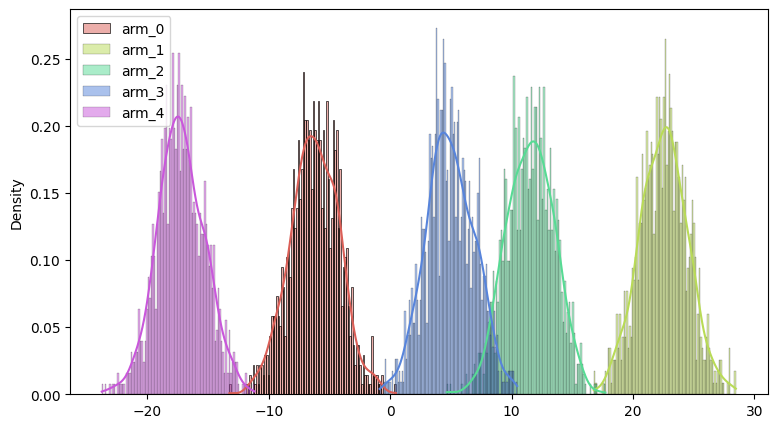

In [12]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [17]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [18]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


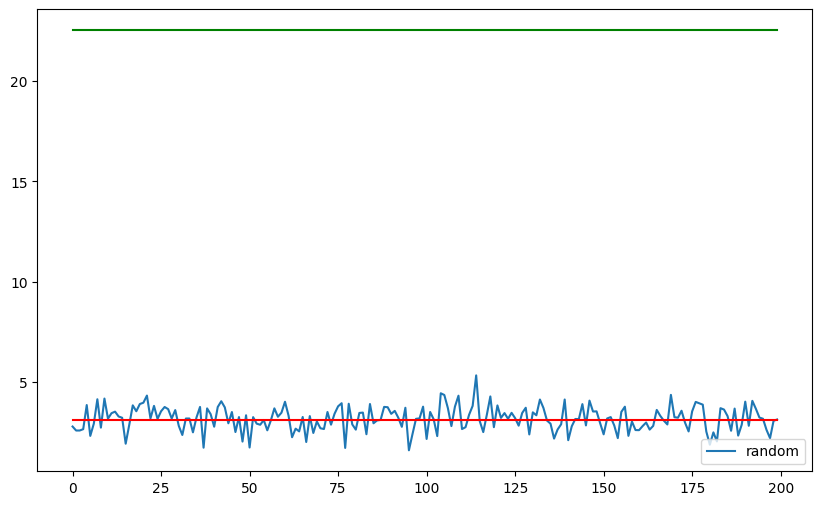

In [19]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 39.590
regret for ep-greedy ep:0.01: 83.764
regret for ep-greedy ep:0.5: 2049.898
regret for ep-greedy ep:0.9: 3510.984


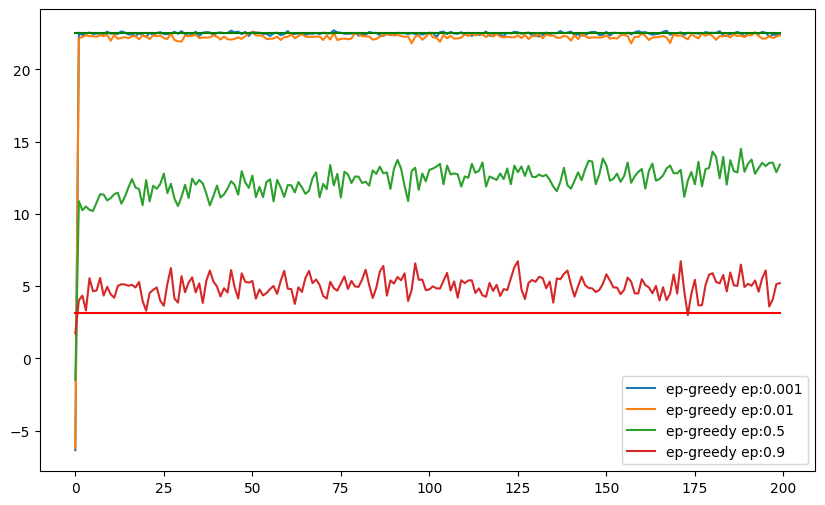

In [20]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 5762.700
regret for softmax tau:1.0: 5763.292
regret for softmax tau:5.0: 5761.934
regret for softmax tau:50.0: 5760.627


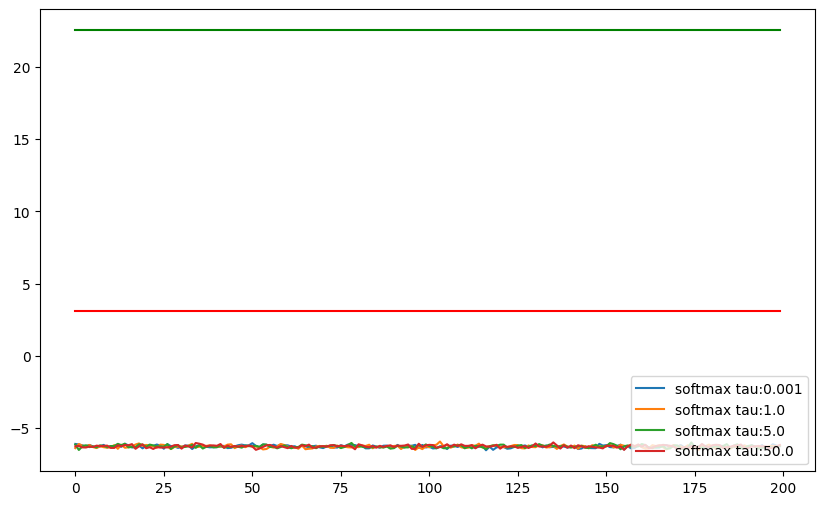

In [21]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB c:4.0: 97.341


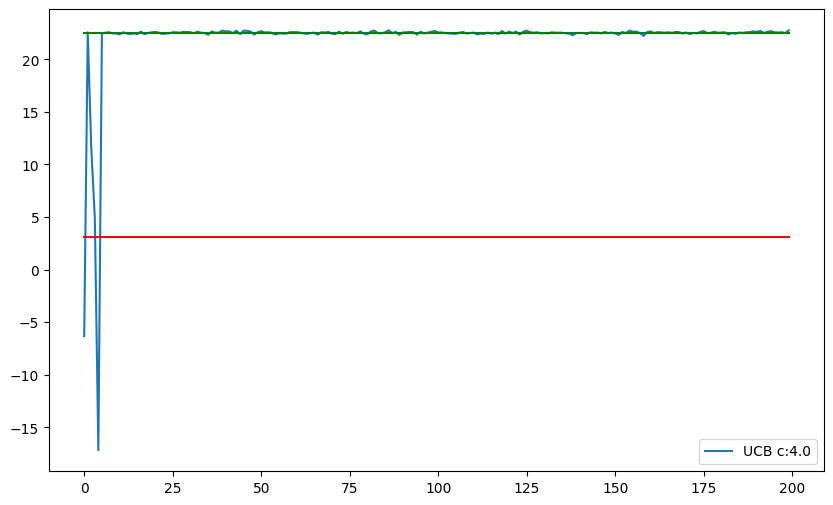

In [24]:
explore_ucb_cs = [4.0]
ucb_policies = [UCB(c, env.arm_ids) for c in explore_ucb_cs]
plot_reward_curve_and_print_regret(env, ucb_policies, timesteps=200, num_runs=500)

#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.

regret for ep-greedy ep:1e-06: 29.010
regret for ep-greedy ep:0.001: 36.917
regret for ep-greedy ep:0.01: 93.992
regret for ep-greedy ep:0.25: 1160.596
regret for ep-greedy ep:0.5: 2059.386
regret for ep-greedy ep:0.75: 2956.801
regret for ep-greedy ep:0.9: 3510.814


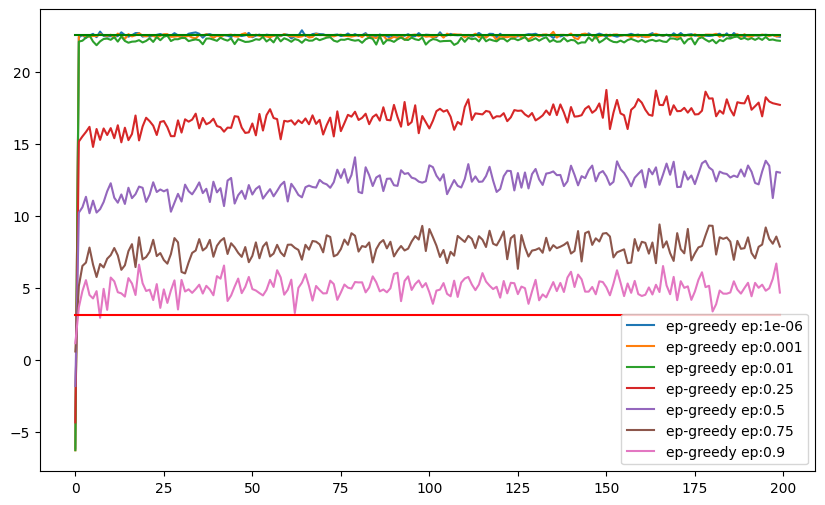

In [25]:
explore_epgreedy_epsilons =  [0.000001,0.001, 0.01,0.25, 0.5,0.75, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

**Epsilon-Greedy Algorithm**



1.   Values between 0 and 1 were tried.
2.   Smaller values of epsilon, give lesser regret, and the model converges faster to optimal value.
3.   Thus, smaller the value of Epsilon, better the exploration, leading to lower regret and faster convergence to optimal arm.


regret for softmax tau:0.001: 5762.839
regret for softmax tau:1.0: 5760.800
regret for softmax tau:5.0: 5762.267
regret for softmax tau:50.0: 5761.770
regret for softmax tau:100.0: 5761.512


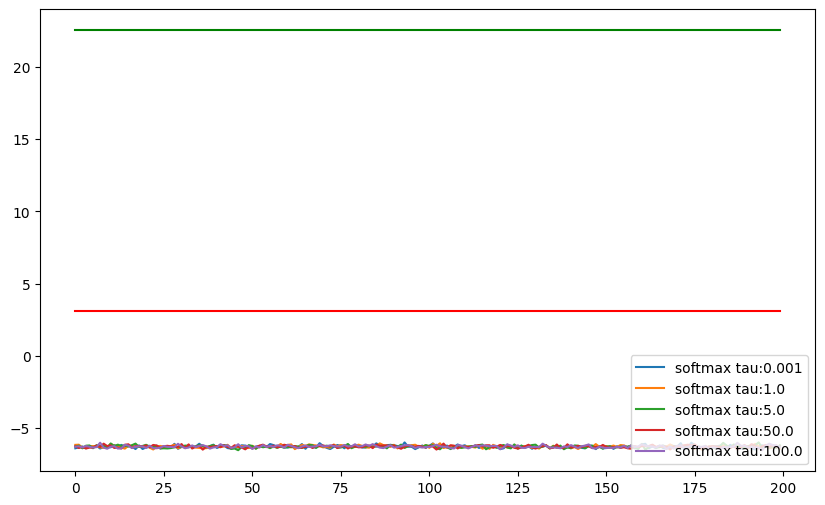

In [26]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0, 100.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

**Softmax Policy**



1.   I can't observe much differnce in the value of regret with changing value of tau.
2.   Possible bug in implementation of selectarm function.



regret for UCB c:0.0001: 97.101
regret for UCB c:0.01: 94.257
regret for UCB c:0.05: 97.876
regret for UCB c:0.1: 96.237
regret for UCB c:4.0: 100.872
regret for UCB c:10: 140.020


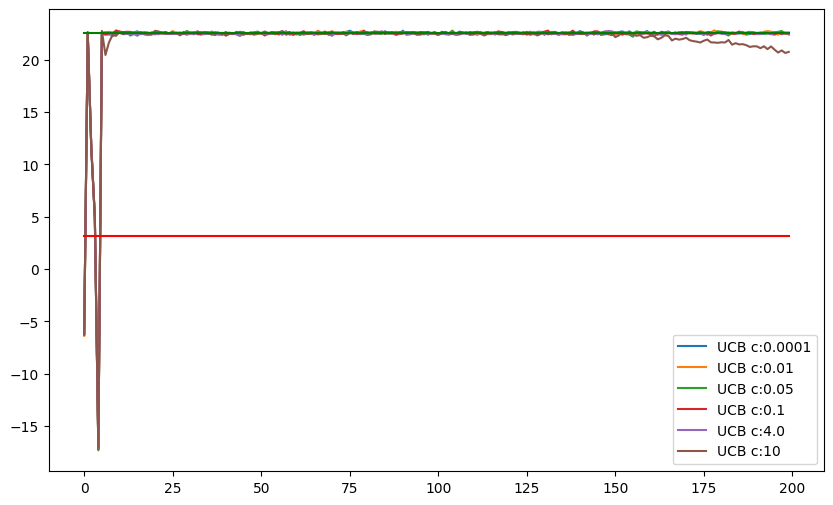

In [28]:
explore_ucb_cs = [0.0001, 0.01, 0.05, 0.1, 4.0, 10]
ucb_policies = [UCB(c, env.arm_ids) for c in explore_ucb_cs]
plot_reward_curve_and_print_regret(env, ucb_policies, timesteps=200, num_runs=500)

**UCB Algorithm**



1.   Average reward shows oscillations before converging to optimal reward.
2.   System more fickle under UCB than Epislon-Greedy Algorithm.
3.   Unlike Softmax, the algorithm converges to optimal reward.

